# Seasonality analysis

In [1]:
import os
import datetime as dt


import pandas as pd
from pandas_datareader import data as pdr

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns

import yfinance as yf

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

from IPython.display import display, Markdown

import requests_cache
from requests import Session
from requests_cache import CacheMixin, SQLiteCache
from requests_ratelimiter import LimiterMixin, MemoryQueueBucket
from pyrate_limiter import Duration, RequestRate, Limiter



class CachedLimiterSession(CacheMixin, LimiterMixin, Session):
    pass





# select the symbol to analyze

# symbol = '2B7K.DE'    # iShares MSCI World SRI UCITS ETF EUR (Acc)
# symbol = 'EUNL.DE'    # iShares Core MSCI World UCITS ETF USD (Acc)
# symbol = 'EURUSD=X'   # USD/EUR
# symbol = 'GBPUSD=X'   # GBP/USD
# symbol = 'AUDUSD=X'   # AUD/USD
# symbol = '^ATX'       # Austrian Traded Index in EUR
# symbol = 'ALV.DE'     # Allianz SE
# symbol = 'ADS.DE'     # adidas AG
symbol = 'EBAY'       # eBay Inc.
# symbol = 'AXP'        # American Express Company
# symbol = 'BTC-USD'    # Bitcoin USD
# symbol = 'ETH-USD'    # Ethereum USD
# symbol = '^GSPC'    # S&P 500




# set maximum number of years to analyze
max_num_of_years = 5



# show seasonality in % instead of currency
seasonalityInPercent = True




def D(text: str):
    display(Markdown(text))






D('## Analysis configuration:')
D(f'* **Symbol selected**: {symbol}')
D(f'* **Max years to analyse**: {dt.date.today().year-1} until earliest {dt.date.today().year-max_num_of_years}')


## Analysis configuration:

* **Symbol selected**: EBAY

* **Max years to analyse**: 2022 until earliest 2018

In [2]:
dirname = '.downloads'
historyFilename = f'{dirname}{os.path.sep}{symbol}_{dt.date.today()}.csv'
cacheFilename = f"{dirname}{os.path.sep}yfinance.cache"

os.makedirs(dirname, exist_ok=True)


session = CachedLimiterSession(
    limiter=Limiter(RequestRate(2, Duration.SECOND*5),  # max 2 requests per 5 seconds
    bucket_class=MemoryQueueBucket),
    backend=SQLiteCache(cacheFilename),
)
ticker = yf.Ticker(symbol, session=session)
df = ticker.history(period='max')

if not os.path.isfile(historyFilename):
    yf.pdr_override()  # <== that's all it takes :-)
    df = pdr.get_data_yahoo(tickers=[symbol], interval="1d")[['Close']]
    df.to_csv(historyFilename)
else:
    df = pd.read_csv(historyFilename, parse_dates=['Date'], index_col=['Date'])




D('## Data loaded:')
D(f'* Close prices of symbol _{symbol}_')
D(f'* From {df.index.min().strftime("%d.%m.%y")} to {df.index.max().strftime("%d.%m.%y")}')

#for (k, v) in ticker.info.items():
#    D(f'* {k}: {v}')


# set correct frequency
annualDf = df.asfreq('d')

# fill up missing values
annualDf = annualDf.fillna(method='ffill')



D('## Statistics:')
print(df.describe())
D('## Data:')
print(df)

## Data loaded:

* Close prices of symbol _EBAY_

* From 24.09.98 to 07.07.23

## Statistics:

             Close
count  6236.000000
mean     22.129993
std      15.997790
min       0.508558
25%      10.004209
50%      16.708754
75%      31.895000
max      80.589996


## Data:

                Close
Date                 
1998-09-24   0.830791
1998-09-25   0.786949
1998-09-28   0.846135
1998-09-29   0.857095
1998-09-30   0.790237
...               ...
2023-06-30  44.689999
2023-07-03  45.230000
2023-07-05  45.029999
2023-07-06  43.849998
2023-07-07  44.259998

[6236 rows x 1 columns]


In [3]:
annualDf = pd.DataFrame(data=df)

# set correct frequency
annualDf = annualDf.asfreq('d')

# fill up missing values
annualDf = annualDf.fillna(method='ffill')

# Drop Feb. 29th of leap years
annualDf = annualDf[~((annualDf.index.month == 2) & (annualDf.index.day == 29))] 

# Create year and day/month columns
annualDf['Year'], annualDf['Day'] = annualDf.index.year, annualDf.index.strftime('%m-%d')

# prepare range of max 5 years or smaller if dataframe is smaller
firstDay = pd.to_datetime(str((annualDf.index.year.min()+1 if ((annualDf.index.year.max()-1) - (annualDf.index.year.min()+1)) < max_num_of_years else annualDf.index.year.max() - max_num_of_years)) + '-01-01')
lastDay = pd.to_datetime(str(annualDf.index.year.max()-1) + '-12-31')
rangeMax5yrs = pd.date_range(firstDay, lastDay, freq='D')

# get actual number of calculated years for dataframe
rangeNumOfYears = rangeMax5yrs.max().year - rangeMax5yrs.min().year + 1

# crop dataframe to max 5 last full years
annualDf = annualDf[rangeMax5yrs.min():rangeMax5yrs.max()].reset_index().drop('Date', axis=1).set_index(['Day', 'Year']).sort_index(level=0)

D('## Initial data overview')
annualDf


## Initial data overview

Close
Day   Year           
01-01 2018  37.740002
      2019  28.070000
      2020  36.110001
      2021  50.250000
      2022  66.500000
...               ...
12-31 2018  28.070000
      2019  36.110001
      2020  50.250000
      2021  66.500000
      2022  41.470001

[1825 rows x 1 columns]

In [4]:
#periodNames = ['seasonal_' + str(i) for i in periods]

#decompose = STL(df['Close'])
#decompose = decompose.fit()

#numOfYears = 0
#retDf = pd.DataFrame()
#for year in sorted(list(set(decompose.seasonal[periodNames[3]].index.year)), reverse=True)[1:-1]:
#    numOfYears += 1
#    if numOfYears > max_num_of_years:
#        break
#    curYearValues = decompose.seasonal[periodNames[3]][str(year) + '-01-01':str(year) + '-12-31'].values
#    if curYearValues.size == 366:
#        curYearValues = np.delete(curYearValues, 59)  # remove Feb. 29 of leap year
#    #annualDf[periodNames[3] + '_' + str(year)] = curYearValues

#D('## Seasonal decomposition')
#decompose

In [5]:
#monthlyDf = pd.DataFrame()
#numOfYears = 0
#for year in sorted(list(set(decompose.seasonal.index.year)), reverse=True)[1:-1]:
#    numOfYears += 1
#    if numOfYears > max_num_of_years:
#        break
#    curYearValues = decompose.seasonal[periodNames[3]][str(year) + '-01-01':str(year) + '-12-31'].resample('M').mean().values
#    if curYearValues.size == 366:
#        curYearValues = np.delete(curYearValues, 59)  # remove Feb. 29 of leap year
#    monthlyDf[periodNames[3] + '_' + str(year)] = curYearValues
#
#
#montlyMean = monthlyDf.mean(axis=1)
#monthlyStd = monthlyDf.std(axis=1)
#monthlyMax = monthlyDf.max(axis=1)
#monthlyDf['mean'] = montlyMean
#monthlyDf['std'] = monthlyStd
#
#monthlyDf['meanPositive'] = monthlyDf['mean'] > 0
#
#range = pd.date_range(str(lastYear) + '-01-01', str(lastYear) + '-12-31', freq='M')
#monthlyDf['date'] = range
#monthlyDf = monthlyDf.set_index('date')
#monthlyDf.index = monthlyDf.index.strftime('%b')
#
#D('## Monthly mean')
#monthlyDf

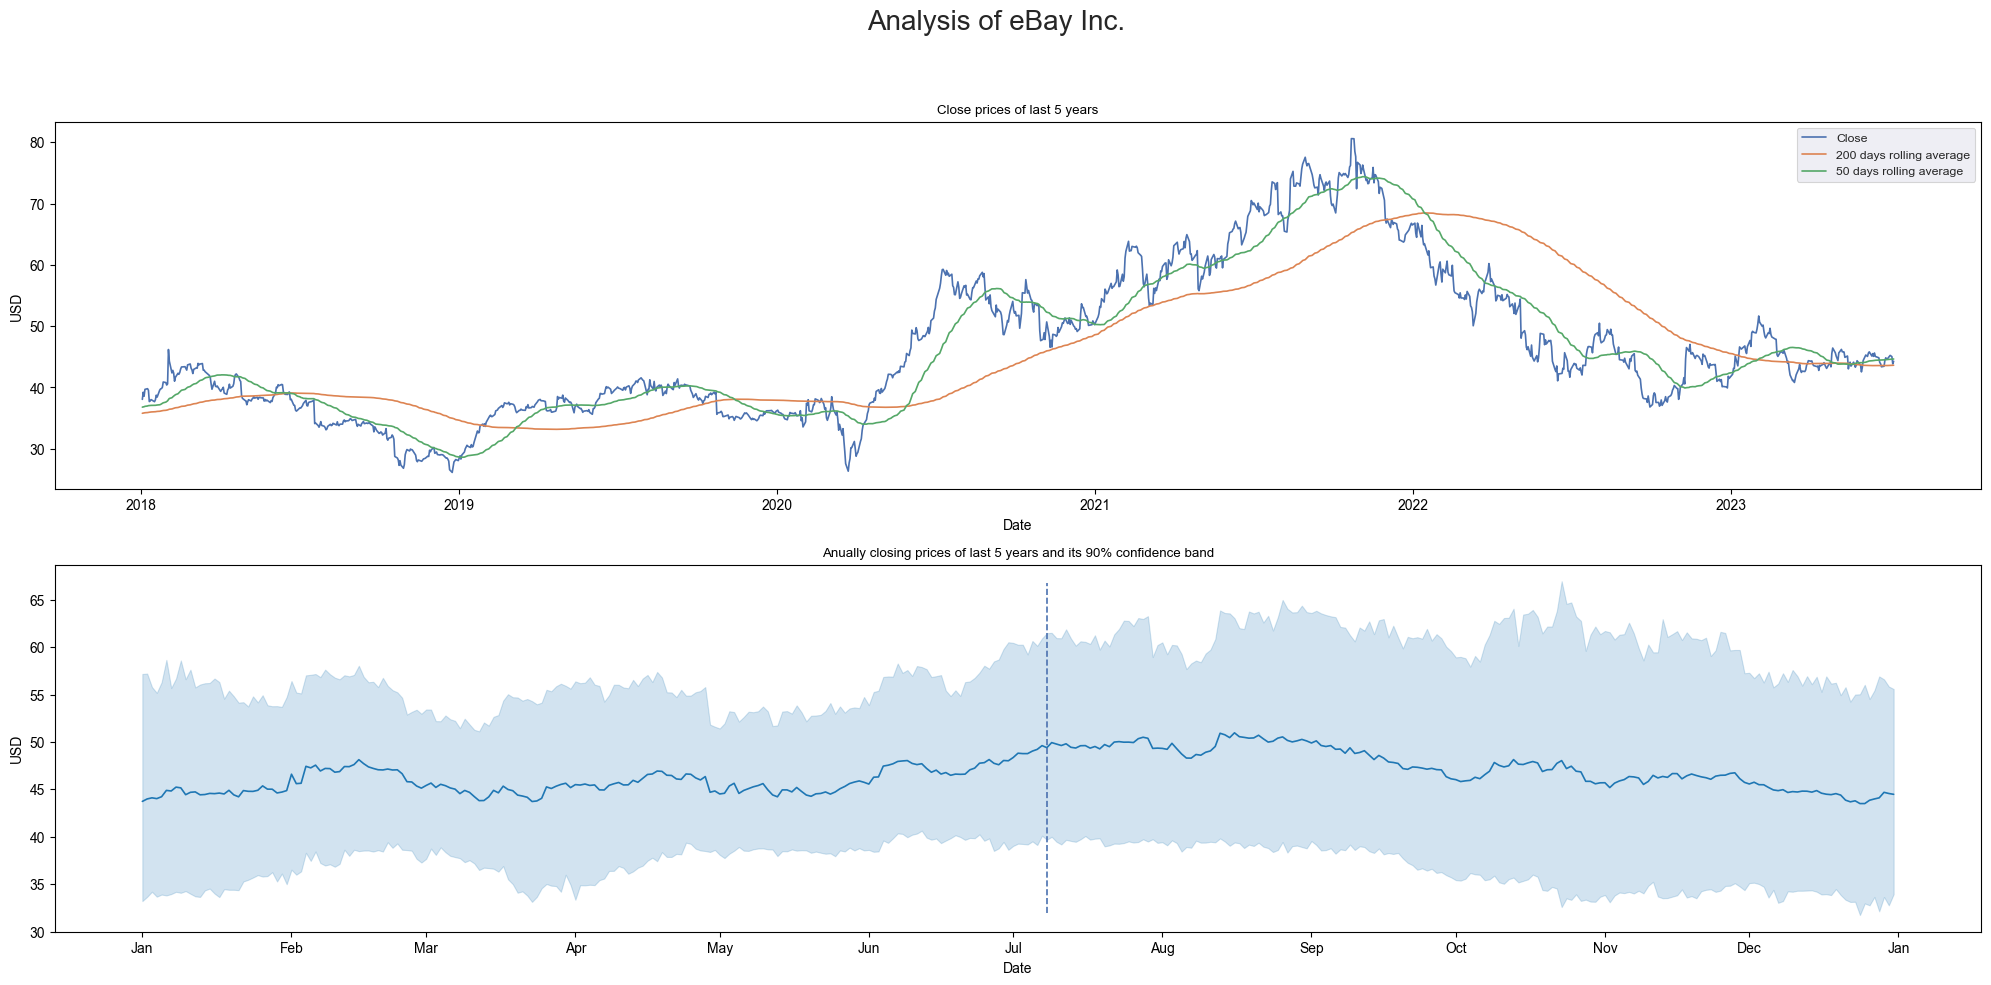

In [6]:



#axs[0].set_title('Overall closing price', fontsize=17)
#axs[0].plot(df['Close'], df['Close'].rolling(rolling_resolution).mean()) # .plot(legend=True, label=str(rolling_resolution) + '-day moving average', grid=True)
#axs[0].set_ylabel(ticker.info['currency'])

#plt.subplot(512)
#plt.title('Overall trend', fontsize=17)
#plt.ylabel(ticker.info['currency'])
#decompose.trend.plot(grid=True)

#plt.subplot(513)
#plt.title(f'Annual min/max/mean closing prices last {max_num_of_years} years', fontsize=17)
#plt.fill_between(annualDf.index, annualDf['min'], annualDf['max'], alpha=0.4)
#plt.ylabel(ticker.info['currency'])
#annualDf['mean'].plot(grid=True)

#plt.subplot(514)
#plt.title(f'Annual seasonality last {max_num_of_years} years', fontsize=17)
#plt.axvline(mdates.date2num(dt.datetime(lastYear, dt.date.today().month, dt.date.today().day)), linestyle='dashed')
#plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b"))
#if seasonalityInPercent:
#    plt.ylabel('%')
#else:
#    plt.ylabel(ticker.info['currency'])
#alpha_value = 1
#for col in annualDf.columns:
#    if col.startswith(periodNames[3]):
#        if seasonalityInPercent:
#            usedAnnualDf = 100 * (annualDf[col] - annualDf[col].iloc[0]) / (annualDf[col].max() - annualDf[col].iloc[0])
#        else:
#            usedAnnualDf = annualDf[col]
#        usedAnnualDf.plot(color='tab:purple', alpha=alpha_value, grid=True)
#        alpha_value = alpha_value * (1 - (2 / numOfYears))

#plt.subplot(515)
#plt.title('Annual monthly mean performance', fontsize=17)
#plt.ylabel(ticker.info['currency'])
#monthlyDf['mean'].plot(kind='bar', yerr=monthlyDf['std'], capsize=4, color=monthlyDf['meanPositive'].map({True: 'tab:green', False: 'tab:red'}), grid=True, rot=0)

#plt.show()

#df['RollingMean'] = df['Close'].rolling(rolling_resolution).mean()

rolling_narrow_resolution = 50
rolling_wide_resolution = 200

fig, axs = plt.subplots(2, 1, figsize=(20, 10))
sns.set_theme('paper')
fig.suptitle(f'Analysis of {ticker.info["longName"]}\n\n', fontsize=20)


# Plot overall closing prices of last x years
overallDf = pd.DataFrame(data=df)
overallDf[f'{rolling_wide_resolution} days rolling average'] = overallDf['Close'].rolling(rolling_wide_resolution).mean()
overallDf[f'{rolling_narrow_resolution} days rolling average'] = overallDf['Close'].rolling(rolling_narrow_resolution).mean()
overallDf = overallDf[rangeMax5yrs.min():pd.to_datetime('today')]
sns.lineplot(data=overallDf, dashes=False, ax=axs[0], legend='full')
axs[0].set_title(f'Close prices of last {rangeNumOfYears} years')
axs[0].set_ylabel(ticker.info['currency'])


# Plot annual closing prices with confidence band
sns.lineplot(data=annualDf, x='Day', y='Close', ax=axs[1], sort=True)
axs[1].xaxis.set_major_locator(mdates.MonthLocator())
axs[1].axvline(f'{"{:02d}".format(dt.date.today().month)}-{"{:02d}".format(dt.date.today().day)}', ymin=0.05, ymax=0.95, linestyle='dashed')
axs[1].set_ylabel('USD')
axs[1].set_xlabel('Date')
axs[1].set_title(f'Anually closing prices of last {rangeNumOfYears} years and its 90% confidence band')
axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%b"))


fig.tight_layout()

